# Projeto GAN com Celeba (Geração de imagens com rostos de celebridades)

In [1]:
import os
from torch.utils.data import Dataset, DataLoader
from PIL import Image
from torchvision import transforms

d:\Ferramentas\anaconda\lib\site-packages\torch\utils\_pytree.py:185: FutureWarning: optree is installed but the version is too old to support PyTorch Dynamo in C++ pytree. C++ pytree support is disabled. Please consider upgrading optree using `python3 -m pip install --upgrade 'optree>=0.13.0'`.
  warnings.warn(


In [2]:
class CelebADataset(Dataset):
    def __init__(self, root_dir, transform=None):
        self.root_dir = root_dir
        self.image_files = sorted(os.listdir(root_dir))
        self.transform = transform

    def __len__(self):
        return len(self.image_files)

    def __getitem__(self, idx):
        img_path = os.path.join(self.root_dir, self.image_files[idx])
        image = Image.open(img_path).convert('RGB')
        if self.transform:
            image = self.transform(image)
        return image, 0

In [ ]:
# Caminho exato para a pasta com as imagens
data_dir = 'img_align_celeba/img_align_celeba'  # No Colab, pode ser isso mesmo se tiver descompactado lá

# Transformações
image_size = 64
transform = transforms.Compose([
    transforms.Resize(image_size),
    transforms.CenterCrop(image_size),
    transforms.ToTensor(),
    transforms.Normalize([0.5] * 3, [0.5] * 3)  # RGB -> [-1, 1]
])

# Dataset e DataLoader
dataset = CelebADataset(root_dir=data_dir, transform=transform)

# DataLoader para visualização (sem subprocessos)
dataloader_vis = DataLoader(dataset, batch_size=128, shuffle=True, num_workers=0)

# DataLoader para treinamento (com paralelismo e otimizações)
dataloader = DataLoader(dataset, batch_size=128, shuffle=True, num_workers=0)

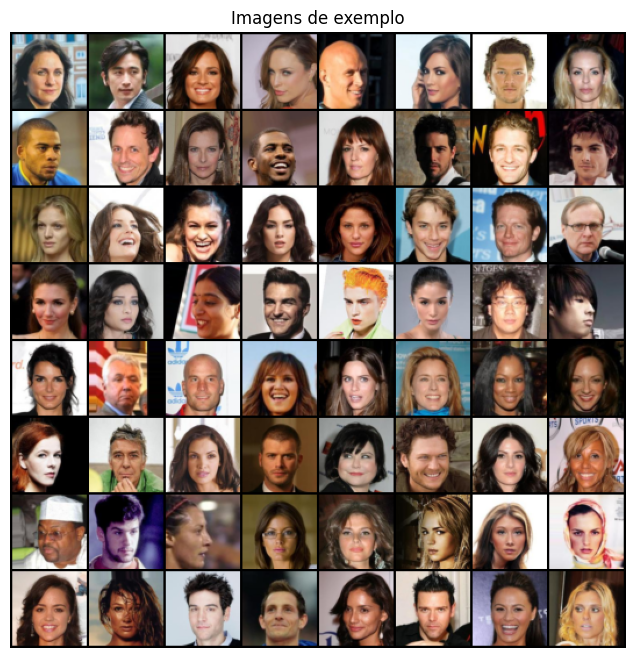

In [4]:
import matplotlib.pyplot as plt
import torchvision.utils as vutils

# Ver algumas imagens
real_batch = next(iter(dataloader_vis))
images = real_batch[0]  # extrai apenas as imagens, ignorando os rótulos

plt.figure(figsize=(8,8))
plt.axis("off")
plt.title("Imagens de exemplo")
plt.imshow(vutils.make_grid(images[:64], padding=2, normalize=True).permute(1, 2, 0))
plt.show(block=False)
plt.pause(1)
plt.close()

---
# Implementação do Gerador

In [5]:
import torch.nn as nn

class Generator(nn.Module):
    def __init__(self, nz, ngf, nc):
        super(Generator, self).__init__()
        self.main = nn.Sequential(
            # Input: Z (vetor de ruído) --> (nz) x 1 x 1
            nn.ConvTranspose2d(nz, ngf * 8, 4, 1, 0, bias=False),
            nn.BatchNorm2d(ngf * 8),
            nn.ReLU(True),

            # (ngf*8) x 4 x 4
            nn.ConvTranspose2d(ngf * 8, ngf * 4, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ngf * 4),
            nn.ReLU(True),

            # (ngf*4) x 8 x 8
            nn.ConvTranspose2d(ngf * 4, ngf * 2, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ngf * 2),
            nn.ReLU(True),

            # (ngf*2) x 16 x 16
            nn.ConvTranspose2d(ngf * 2, ngf, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ngf),
            nn.ReLU(True),

            # (ngf) x 32 x 32
            nn.ConvTranspose2d(ngf, nc, 4, 2, 1, bias=False),
            nn.Tanh()  # Saída: RGB 3 x 64 x 64
        )

    def forward(self, input):
        return self.main(input)


## Parâmetros:

* ### nz: tamanho do vetor de ruído (ex: 100)

* ### ngf: número de filtros do gerador (ex: 64)

* ### nc: número de canais de saída (3 para RGB)

---
# Implementação do Discriminador 

In [6]:
class Discriminator(nn.Module):
    def __init__(self, nc, ndf):
        super(Discriminator, self).__init__()
        self.main = nn.Sequential(
            # Entrada: imagem RGB 3 x 64 x 64
            nn.Conv2d(nc, ndf, 4, 2, 1, bias=False),
            nn.LeakyReLU(0.2, inplace=True),

            # (ndf) x 32 x 32
            nn.Conv2d(ndf, ndf * 2, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ndf * 2),
            nn.LeakyReLU(0.2, inplace=True),

            # (ndf*2) x 16 x 16
            nn.Conv2d(ndf * 2, ndf * 4, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ndf * 4),
            nn.LeakyReLU(0.2, inplace=True),

            # (ndf*4) x 8 x 8
            nn.Conv2d(ndf * 4, ndf * 8, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ndf * 8),
            nn.LeakyReLU(0.2, inplace=True),

            # (ndf*8) x 4 x 4
            nn.Conv2d(ndf * 8, 1, 4, 1, 0, bias=False),
            nn.Sigmoid()  # Saída: probabilidade de ser real (1) ou falsa (0)
        )

    def forward(self, input):
        return self.main(input)


## Parâmetros:

* ### nc: número de canais da imagem (3 para RGB)

* ### ndf: número de filtros do discriminador (ex: 64)

---
# Função de Perda

In [7]:
criterion = nn.BCELoss()

---
# Pesos do modelo

In [8]:
import torch

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

nz = 100  # Dimensão do vetor de ruído (input do gerador)
ngf = 64  # Tamanho dos feature maps no gerador
ndf = 64  # Tamanho dos feature maps no discriminador
nc = 3    # Número de canais da imagem de saída (3 para RGB)

# Criação das redes
netG = Generator(nz, ngf, nc).to(device)
netD = Discriminator(nc, ndf).to(device)

In [9]:
def weights_init(m):
    if isinstance(m, nn.Conv2d) or isinstance(m, nn.ConvTranspose2d):
        nn.init.normal_(m.weight.data, 0.0, 0.02)
    elif isinstance(m, nn.BatchNorm2d):
        nn.init.normal_(m.weight.data, 1.0, 0.02)
        nn.init.constant_(m.bias.data, 0)
        
netG.apply(weights_init)
netD.apply(weights_init)

Discriminator(
  (main): Sequential(
    (0): Conv2d(3, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (1): LeakyReLU(negative_slope=0.2, inplace=True)
    (2): Conv2d(64, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (3): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (4): LeakyReLU(negative_slope=0.2, inplace=True)
    (5): Conv2d(128, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (6): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (7): LeakyReLU(negative_slope=0.2, inplace=True)
    (8): Conv2d(256, 512, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (9): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (10): LeakyReLU(negative_slope=0.2, inplace=True)
    (11): Conv2d(512, 1, kernel_size=(4, 4), stride=(1, 1), bias=False)
    (12): Sigmoid()
  )
)

---
# Otimizadores Adam

In [10]:
lr = 0.0002
beta1 = 0.5

optimizerD = torch.optim.Adam(netD.parameters(), lr=lr, betas=(beta1, 0.999))
optimizerG = torch.optim.Adam(netG.parameters(), lr=lr, betas=(beta1, 0.999))

---
# Treinamento

In [12]:
import time
import torchvision.utils as vutils
import os

num_epochs = 50
fixed_noise = torch.randn(64, nz, 1, 1, device=device)

print("Iniciando o treinamento...")

for epoch in range(num_epochs):
    epoch_start_time = time.time()  # ⏰ marca o início da época

    for i, data in enumerate(dataloader, 0):
        batch_start_time = time.time()  # ⏰ marca o início do batch

        netD.zero_grad()
        real_images = data[0].to(device)
        b_size = real_images.size(0)
        label = torch.full((b_size,), 1., device=device)

        output = netD(real_images).view(-1)
        errD_real = criterion(output, label)
        errD_real.backward()
        D_x = output.mean().item()

        noise = torch.randn(b_size, nz, 1, 1, device=device)
        fake_images = netG(noise)
        label.fill_(0.)

        output = netD(fake_images.detach()).view(-1)
        errD_fake = criterion(output, label)
        errD_fake.backward()
        D_G_z1 = output.mean().item()

        errD = errD_real + errD_fake
        optimizerD.step()

        netG.zero_grad()
        label.fill_(1.)

        output = netD(fake_images).view(-1)
        errG = criterion(output, label)
        errG.backward()
        D_G_z2 = output.mean().item()
        optimizerG.step()

        batch_end_time = time.time()  # ⏰ marca o final do batch
        batch_duration = batch_end_time - batch_start_time

        if i % 100 == 0:
            print(f"[{epoch}/{num_epochs}][{i}/{len(dataloader)}] "
                  f"Loss_D: {errD.item():.4f} Loss_G: {errG.item():.4f} "
                  f"D(x): {D_x:.4f} D(G(z)): {D_G_z1:.4f}/{D_G_z2:.4f} "
                  f"| Tempo por batch: {batch_duration:.2f} segundos")

    epoch_end_time = time.time()  # ⏰ marca o final da época
    epoch_duration = epoch_end_time - epoch_start_time
    print(f"⏱️ Época {epoch} finalizada em {epoch_duration:.2f} segundos ({epoch_duration/60:.2f} minutos)")

    with torch.no_grad():
        fake = netG(fixed_noise).detach().cpu()
    os.makedirs("images", exist_ok=True)
    vutils.save_image(fake, f"images/fake_epoch_{epoch:03d}.png", normalize=True)


Iniciando o treinamento...
[0/50][0/1583] Loss_D: 0.4429 Loss_G: 4.7275 D(x): 0.8911 D(G(z)): 0.2222/0.0206 | Tempo por batch: 1.66 segundos
[0/50][100/1583] Loss_D: 0.2635 Loss_G: 4.3393 D(x): 0.8915 D(G(z)): 0.1050/0.0259 | Tempo por batch: 1.67 segundos
[0/50][200/1583] Loss_D: 0.5872 Loss_G: 4.4073 D(x): 0.8408 D(G(z)): 0.2690/0.0228 | Tempo por batch: 1.65 segundos
[0/50][300/1583] Loss_D: 2.3112 Loss_G: 5.5012 D(x): 0.2406 D(G(z)): 0.0017/0.0214 | Tempo por batch: 1.63 segundos
[0/50][400/1583] Loss_D: 0.4336 Loss_G: 3.5804 D(x): 0.8153 D(G(z)): 0.1343/0.0466 | Tempo por batch: 1.64 segundos
[0/50][500/1583] Loss_D: 0.4946 Loss_G: 3.7799 D(x): 0.8162 D(G(z)): 0.1860/0.0408 | Tempo por batch: 1.65 segundos
[0/50][600/1583] Loss_D: 0.6999 Loss_G: 4.5941 D(x): 0.8131 D(G(z)): 0.3095/0.0186 | Tempo por batch: 1.66 segundos
[0/50][700/1583] Loss_D: 0.5675 Loss_G: 4.8320 D(x): 0.8918 D(G(z)): 0.3077/0.0151 | Tempo por batch: 1.81 segundos
[0/50][800/1583] Loss_D: 0.5022 Loss_G: 2.9592 